COMP9444

Considering the pandemic in the past two years, designing corresponding mask face detection and recognition algorithms based on mask face data to help with face recognition has become a need in some areas. In this CV project, ResNet is used to train a binary task. To investigate the performance of Alexnet, VGG, Resnet34, and Resnet18 in this task, we built up data enhancement, datasets, dataloader, train structure, and tested them with different setups. The weakness of this experiment is that the data used is idealized (lack of side faces, mask types, etc.) and no test training module for inappropriate mask-wearing is added. In the future, this experiment can expand the test scope, testing the impact of epoch size on the experimental results, etc., and the use of the CascadeClassifier module to extract the face part for cameras' real-time testing is possible as well.

*Introduction and problem statement: This is a CV project that uses resnet to train a binary task(mask, no mask).In this project, we build up data enhancement, datasets, dataloader, train structure(train test loop, optimizer, loss function, and figure plot) and test a CNN model and use resnet34, resnet18, and vgg with different set up(learning rate, optimizer, datasets volume...) to explore the performance in this task.
*Data Sources: we use total of 3508 different images, 3008 images for training (1504 mask 1504 no mask), and 500 images for testing (250 mask 250 no mask), the data source link is here: https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset
*Exploratory Analysis of Data:
    1. Transforms(This is data enhancement, we use cropping, flipping, rotation, color changing, and normalizing to enhance the data in order to increase generalization capability and prevent overfitting)
    2.Datasets & DataLoaders(we transform data into dataloader, the dataloader include X(picture matrix) and y(one hot coding of mask or no maks))
    3.NeuralNetwork(CNN model and transfer learning （resnet18, resnet34 and vgg）, it also prints the details of the network to check)
    4.Device(can run on GPU, if not run on CPU)
    5.Train and Test Loop(get the data from dataloader and do the training and testing)
    6.Optimizing Model Parameters(optimizer and loss function initialization)
    7.Plot function(plot the test acc and loss)
    8.Fit function(In epochs loops, call 4,5,6,7 functions or parameters)
    9.Testing(test resnet34 and resnet18 with different set up(learning rate, optimizer, datasets volume...))
    The most challenging aspect is to avoid overfitting,if the images of acc and loss oscillate too much repeatedly, it may mean that the model is over fitted,to prevent over fitting, we try to use different data sources, increase data volume, increase data enhancement and adjust learning rate and optimizer to test.
*Models and/or Methods: We use the residual network model resnet18 and resnet34 proposed by He Kaiming. We retain the previous layer and only train the final output linear layer.We used the training method recommended by the official website of Pytorch (use the model to calculate the predictive value in the train loop, and put the actual value into the loss method to calculate the loss value, use the optimizer to adjust the parameters for gradient descent, and for test loop, only calculate the accuracy and loss value)
*Results and Discussion is at the 9.Testing

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

1.Transforms
It is mainly data enhancement, converting NumPy to tensor format and normalizing the original data. Based on the different data augmentations used for initialization in the self-built model and the migrated learning models, the self-built model and the three migrated learning models are not comparable.

In [38]:
'''
Transforms(Data enhancement)
'''
data_transforms = {
    'Train': transforms.Compose([
        # Can add more
        transforms.Resize(256),
        transforms.CenterCrop(224), # center crop 224*224 for resnet
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal rollover with a probability of 0.5
        transforms.RandomRotation(45), # random rotate-45 degree
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # Brightness, contrast, saturation, hue
        transforms.RandomGrayscale(p=0.025), # random gray scale
        transforms.ToTensor(), # Transfer to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Treatment of mean and standard deviation
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal rollover with a probability of 0.5
        transforms.RandomRotation(45), # random rotate-45 degree
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # Brightness, contrast, saturation, hue
        transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

2.Datasets & DataLoaders
Call data_transforms and put the image data in the dataloader, the bath size is set to 256 (the benefits of larger batch size: the memory utilization is improved, the parallelization efficiency of large matrix multiplication is increased; the number of iterations required to run through an epoch (full data set) is reduced, and the processing speed for the same amount of data is further accelerated; within a certain range. In general, the larger the Batch_Size, the more accurate its descent direction will be, and the less training oscillation will occur. Based on the folder name for the unique hot encoding as Y-value and, image data as x-value, and XY-value will be loaded together into the dataloader in the final shuffle to disrupt the order.

In [39]:
'''
Datasets class
'''
class ImageDataset:
    def __init__(self, img_dir, data_transform):
        self.img_dir = img_dir
        self.transform = data_transform
        self.datasets_dict = {}
        self.folder = ['Train', 'Test']
    def make_datasets(self):
        for sets_type in self.folder:
            self.datasets_dict[sets_type] = datasets.ImageFolder(os.path.join(self.img_dir, sets_type), data_transforms[sets_type])
        return self.datasets_dict

In [40]:
'''
DataLoader function
'''
def dataloader(img_dataset):
    data_loader = {}
    for x in list(img_dataset.keys()):
        data_loader[x] = torch.utils.data.DataLoader(img_dataset[x], batch_size=256, shuffle=True)
    return data_loader

Call the previously declared ImageDataset class and the dataloader method to make dataloader.

In [41]:
# set up a datasets
img_dir = "Set"
sets = ImageDataset(img_dir, data_transforms).make_datasets()
data_loader = dataloader(sets)

3.NeuralNetwork
A Network class is provided with three models for migration learning (vgg,resnet18, resnet34). Calling the get_network method initializes the selected model and prints the model structure and the parameters to be learned and adjusted. The parameter configurations in previous convolutional and pooling layers among these three models are not updated, where the last linear output layer, the out_features are modified and set to be derivable.

In [42]:
class Network:
    def __init__(self, network_type, feature_extract):
        self.net_type = network_type
        self.feature_extract = feature_extract

    def get_network(self):
        model_ft = ""
        if self.net_type == "resnet18":
            model_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        elif self.net_type == "resnet34":
            model_ft = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
        elif self.net_type == "vgg11":
            model_ft = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.DEFAULT)

        # whether to use original para
        if self.feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        if self.net_type == "resnet18" or self.net_type == "resnet34":
            num_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_features, 2)
        elif self.net_type == "vgg11":
            model_ft.classifier._modules['6'] = nn.Linear(4096, 2)

        if model_ft == "":
            print("Sorry don't have this network yet!")
        else:
            print(model_ft)
            print("-"*20)
            print("parameters need to learn:")
            for name, param in model_ft.named_parameters():
                if param.requires_grad:
                    print("\t", name)
        return model_ft


3.1 SelfNet
The SelfNet class provides a CNN model that we wrote ourselves. Compared with the residual network like resnet, the vgg model is relatively less complex. However, for this binary classification task with high quality image dataset and obvious features, vgg will be a bit too big to be used. Therefore, based on the vgg model, our model only keep the first two convolutional layers and the pooling layer, and the relu activation function is still being used in between the convolutional and pooling layers to keep the gradient.
The number of input_features and out_features are changed to reduce the computational pressure. For the fully-connected linear layers, similarly, only the first two linear layers are retained, the number of input_features and out_features is reduced. The relu activation function and dropout rate in the two linear layers are retained as well.

In [43]:
class SelfNet(nn.Module):
    def __init__(self):
        super(SelfNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*56*56, 120),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=120, out_features=2, bias=True)
        )
        # x = torch.randn(256, 3, 224, 224)
        # o = self.conv(x)
        # print(o.shape)
    def forward(self, input):
        batch_size = input.size(0)
        input = self.conv(input)
        input = input.view(batch_size, 16*56*56)
        out = self.fc(input)
        return out

In [44]:
self_network = SelfNet()
print(self_network)
for param in self_network.parameters():
    param.requires_grad = True
for name, param in self_network.named_parameters():
    if param.requires_grad:
        print("\t", name)

SelfNet(
  (conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=50176, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=2, bias=True)
  )
)
	 conv.0.weight
	 conv.0.bias
	 conv.3.weight
	 conv.3.bias
	 fc.0.weight
	 fc.0.bias
	 fc.3.weight
	 fc.3.bias


In [45]:
resnet18 = Network("resnet18", True).get_network()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
resnet34 = Network("resnet34", True).get_network()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
vgg11 = Network("vgg11", True).get_network()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

4.Device

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
def check_device():
    if torch.cuda.is_available():
        print("Start on GPU")
    else:
        print("Start on CPU")

5.Train and Test Loop
We borrowed the model training method from the pytorch website, rewriting and improving have been done for it to be compatible with GPU operations. and passing in two lists to record 
The loss and Accuracy values are recorded after each epoch in test_loop.
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [50]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.to(device)
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        # grad,backward,optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, out_pred = torch.max(model(X), 1)
        # collect some value can output
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)

            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # if you want to check predict and real value, run this
            # print(f"predict:{out_pred}\n, real:{y}")

def test_loop(dataloader, model, loss_fn, corr_list, test_loss_list):
    model.to(device)
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # collect some value can output
    test_loss /= num_batches
    correct /= size
    corr_list.append(correct*100)
    test_loss_list.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

6.Optimizing Model Parameters
The loss functions are computed using cross-entropy.
For the optimizer, we used SGD and Adam optimizers in the test and set different learning rates to observe the effect of model learning.

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.1)
optimizer_resnet34 = optim.Adam(resnet34.parameters(), lr=0.0001)
optimizer_vgg = optim.Adam(vgg11.parameters(), lr=0.0001)
optimizer_self = optim.Adam(self_network.parameters(), lr=0.0001)

7.Plot function
This method is used to plot the loss values and Accuracy values recorded in test_loop.

In [53]:
def draw_result(figure, epoch_time, tittle, y_label, x_label):
    y = np.array(figure)
    x = np.array(epoch_time)
    plt.plot(x, y)

    plt.title(tittle)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

8.Fit function
The train_loop method, test_loop method and draw_result method will be called and encapsulated here, which will print the training data and print the resulting graph.

In [54]:
def fit(epoch, resnet, loss_function, optimizer):
    corr_list, test_loss_list = [], []
    check_device()
    for t in range(epoch):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(data_loader["Train"], resnet, loss_function, optimizer)
        test_loop(data_loader["Test"], resnet, loss_function, corr_list, test_loss_list)
    draw_result(corr_list, [i for i in range(1, len(corr_list)+1)], "Accuracy result", "Accuracy(%)", "epoch")
    draw_result(test_loss_list, [i for i in range(1, len(test_loss_list)+1)], "Loss result", "Loss", "epoch")
    print("Done!")

----------------------------------------------9.TESTING(*Result)----------------------------------------------------------------

Test0, which aims to train our own CNN model, cannot control the variables without comparability because we use a different data augmentation than migration learning.
(Self_network, epoch=50, optimizer=Adam lr0.0001, loss_function=CrossEntropyLoss, Train dataset volume=3008)
It can be seen that the model learns quickly and the accuracy improves to 96.5% in the first epoch. After which there are small fluctuations, but increases overall. After epoch=20, it tends to be stable, and the accuracy rate fluctuates between 99.5% and 100%.
The loss rate drops sharply in the first 8 epochs and stabilizes at about 0.003 at epoch=10.

Start on CPU
Epoch 1
-------------------------------
loss: 0.688091  [    0/ 3008]
loss: 0.703108  [  512/ 3008]
loss: 0.599338  [ 1024/ 3008]
loss: 0.531145  [ 1536/ 3008]
loss: 0.514358  [ 2048/ 3008]
loss: 0.477115  [ 2560/ 3008]
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.393093 

Epoch 2
-------------------------------
loss: 0.417811  [    0/ 3008]
loss: 0.376658  [  512/ 3008]
loss: 0.352057  [ 1024/ 3008]
loss: 0.297482  [ 1536/ 3008]
loss: 0.248622  [ 2048/ 3008]
loss: 0.241565  [ 2560/ 3008]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.196761 

Epoch 3
-------------------------------
loss: 0.215715  [    0/ 3008]
loss: 0.197698  [  512/ 3008]
loss: 0.164497  [ 1024/ 3008]
loss: 0.182552  [ 1536/ 3008]
loss: 0.160686  [ 2048/ 3008]
loss: 0.142813  [ 2560/ 3008]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.100337 

Epoch 4
-------------------------------
loss: 0.129595  [    0/ 3008]
loss: 0.109986  [  512/ 3008]
loss: 0.096392  [ 1024/ 3008]
loss: 0.071196  [ 1536/ 3008]
loss: 0.081

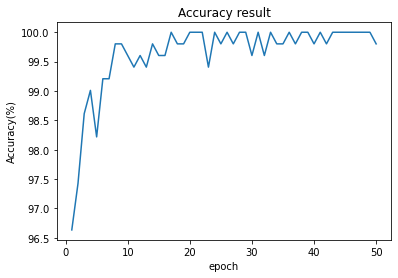

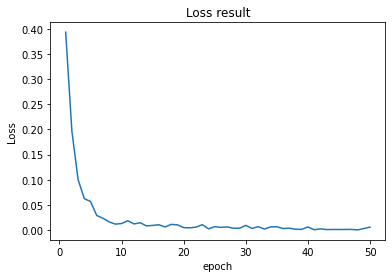

Done!


In [18]:
fit(50, self_network, loss_fn, optimizer_self)

Test1  experimental group(try to test with a lower data volume)
(Resnet18, epoch=50, optimizer=Adam lr0.0001, loss_function=CrossEntropyLoss, Train dataset volume=2008)
Compare with test2, the increase speed of test 1 accuracy will be slower, and the decrease speed of loss value will become full, but there is no significant difference between the highest accuracy value and the lowest loss value.

Start on CPU
Epoch 1
-------------------------------
loss: 0.997873  [    0/ 2008]
loss: 0.953247  [  512/ 2008]
loss: 0.910179  [ 1024/ 2008]
loss: 0.850814  [ 1536/ 2008]
Test Error: 
 Accuracy: 44.0%, Avg loss: 0.876482 

Epoch 2
-------------------------------
loss: 0.836567  [    0/ 2008]
loss: 0.848791  [  512/ 2008]
loss: 0.796800  [ 1024/ 2008]
loss: 0.816760  [ 1536/ 2008]
Test Error: 
 Accuracy: 33.8%, Avg loss: 0.807593 

Epoch 3
-------------------------------
loss: 0.810033  [    0/ 2008]
loss: 0.786476  [  512/ 2008]
loss: 0.789242  [ 1024/ 2008]
loss: 0.791403  [ 1536/ 2008]
Test Error: 
 Accuracy: 35.5%, Avg loss: 0.805432 

Epoch 4
-------------------------------
loss: 0.760789  [    0/ 2008]
loss: 0.745786  [  512/ 2008]
loss: 0.784733  [ 1024/ 2008]
loss: 0.777233  [ 1536/ 2008]
Test Error: 
 Accuracy: 40.2%, Avg loss: 0.773458 

Epoch 5
-------------------------------
loss: 0.763244  [    0/ 2008]
loss: 0.743971  [  512/ 2008]
loss: 0.722649  [ 1024/ 2008]
loss: 0.7

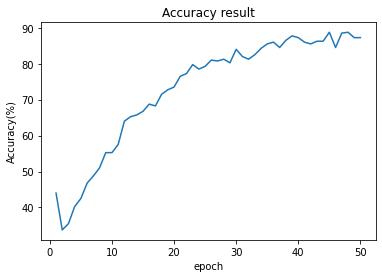

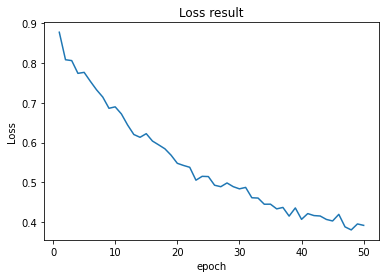

Done!


In [31]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test2 Control group.
(Resnet18 epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008)

Start on CPU
Epoch 1
-------------------------------
loss: 0.665839  [    0/ 3008]
loss: 0.661167  [  512/ 3008]
loss: 0.636490  [ 1024/ 3008]
loss: 0.641574  [ 1536/ 3008]
loss: 0.614802  [ 2048/ 3008]
loss: 0.621395  [ 2560/ 3008]
Test Error: 
 Accuracy: 38.4%, Avg loss: 0.762403 

Epoch 2
-------------------------------
loss: 0.589779  [    0/ 3008]
loss: 0.586418  [  512/ 3008]
loss: 0.606531  [ 1024/ 3008]
loss: 0.574572  [ 1536/ 3008]
loss: 0.563577  [ 2048/ 3008]
loss: 0.588765  [ 2560/ 3008]
Test Error: 
 Accuracy: 48.7%, Avg loss: 0.730514 

Epoch 3
-------------------------------
loss: 0.554855  [    0/ 3008]
loss: 0.533805  [  512/ 3008]
loss: 0.555940  [ 1024/ 3008]
loss: 0.541718  [ 1536/ 3008]
loss: 0.530988  [ 2048/ 3008]
loss: 0.513677  [ 2560/ 3008]
Test Error: 
 Accuracy: 46.9%, Avg loss: 0.730326 

Epoch 4
-------------------------------
loss: 0.519798  [    0/ 3008]
loss: 0.512457  [  512/ 3008]
loss: 0.510102  [ 1024/ 3008]
loss: 0.488593  [ 1536/ 3008]
loss: 0.472

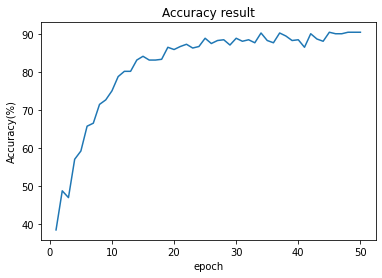

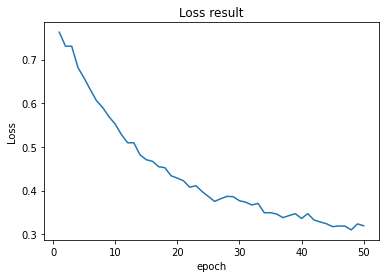

Done!


In [49]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test3 experimental group(Try with higher add learning rate).
(Resnet18, epoch=50, optimizer=Adam lr0.001, loss_function=CrossEntropyLoss, Train dataset volume=3008)
Compared with Test 2, the image of accuracy and loss value fluctuates significantly, and the learning of accuracy value increases rapidly. It seems that the climbing of accuracy value has been skipped in the image, and it is directly improved to 88.7%.

Start on CPU
Epoch 1
-------------------------------
loss: 0.702680  [    0/ 3008]
loss: 0.701690  [  512/ 3008]
loss: 0.567292  [ 1024/ 3008]
loss: 0.568947  [ 1536/ 3008]
loss: 0.497644  [ 2048/ 3008]
loss: 0.452737  [ 2560/ 3008]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.449196 

Epoch 2
-------------------------------
loss: 0.474101  [    0/ 3008]
loss: 0.420806  [  512/ 3008]
loss: 0.390553  [ 1024/ 3008]
loss: 0.335942  [ 1536/ 3008]
loss: 0.357040  [ 2048/ 3008]
loss: 0.292553  [ 2560/ 3008]
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.374632 

Epoch 3
-------------------------------
loss: 0.282154  [    0/ 3008]
loss: 0.287962  [  512/ 3008]
loss: 0.236647  [ 1024/ 3008]
loss: 0.228402  [ 1536/ 3008]
loss: 0.246739  [ 2048/ 3008]
loss: 0.195483  [ 2560/ 3008]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.335495 

Epoch 4
-------------------------------
loss: 0.210891  [    0/ 3008]
loss: 0.200815  [  512/ 3008]
loss: 0.189026  [ 1024/ 3008]
loss: 0.178347  [ 1536/ 3008]
loss: 0.172

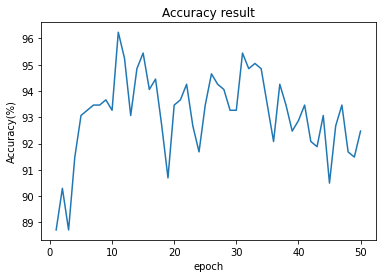

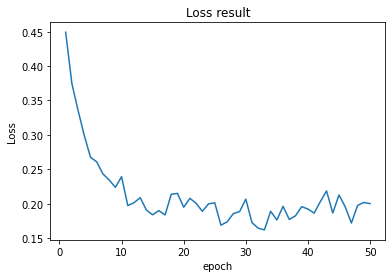

Done!


In [67]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test4 experimental group (try if use SGD instead).
(Resnet18, epoch=50, optimizer=SGD lr0.0001 mon=0.1, loss_function=CrossEntropyLoss, train dataset volume=3008)
The same as test2 is the accuracy of the model increases rapidly, and the loss value decreases rapidly. However, the accuracy fluctuates between 91-94.5, and the fluctuation range is half of test2.

Start on CPU
Epoch 1
-------------------------------
loss: 0.014260  [    0/ 3008]
loss: 0.012492  [  512/ 3008]
loss: 0.015880  [ 1024/ 3008]
loss: 0.010835  [ 1536/ 3008]
loss: 0.010486  [ 2048/ 3008]
loss: 0.009382  [ 2560/ 3008]
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.194349 

Epoch 2
-------------------------------
loss: 0.017736  [    0/ 3008]
loss: 0.012660  [  512/ 3008]
loss: 0.011972  [ 1024/ 3008]
loss: 0.007724  [ 1536/ 3008]
loss: 0.009451  [ 2048/ 3008]
loss: 0.012485  [ 2560/ 3008]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.171774 

Epoch 3
-------------------------------
loss: 0.007048  [    0/ 3008]
loss: 0.011468  [  512/ 3008]
loss: 0.011309  [ 1024/ 3008]
loss: 0.018711  [ 1536/ 3008]
loss: 0.012967  [ 2048/ 3008]
loss: 0.012651  [ 2560/ 3008]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.208880 

Epoch 4
-------------------------------
loss: 0.012671  [    0/ 3008]
loss: 0.009894  [  512/ 3008]
loss: 0.010030  [ 1024/ 3008]
loss: 0.009875  [ 1536/ 3008]
loss: 0.010

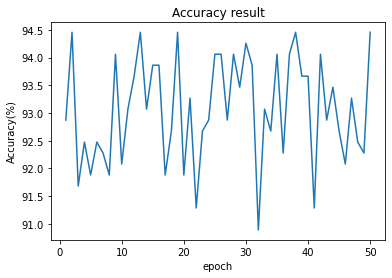

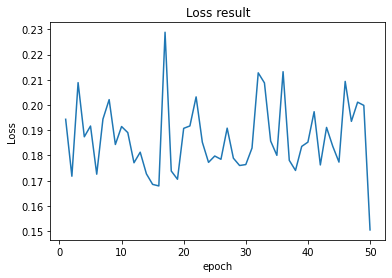

Done!


In [73]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test5 experimental groupTry (Try if use resnet34)
(Resnet34 epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008)
Compared with the test2 image, the vibration is more obvious. The model may be over fitted, and the same learning rate may be a little high for resnet34.

Start on CPU
Epoch 1
-------------------------------
loss: 0.738052  [    0/ 3008]
loss: 0.708985  [  512/ 3008]
loss: 0.737927  [ 1024/ 3008]
loss: 0.691584  [ 1536/ 3008]
loss: 0.642181  [ 2048/ 3008]
loss: 0.656033  [ 2560/ 3008]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.650447 

Epoch 2
-------------------------------
loss: 0.687585  [    0/ 3008]
loss: 0.661301  [  512/ 3008]
loss: 0.641440  [ 1024/ 3008]
loss: 0.655422  [ 1536/ 3008]
loss: 0.650678  [ 2048/ 3008]
loss: 0.646027  [ 2560/ 3008]
Test Error: 
 Accuracy: 63.0%, Avg loss: 0.631456 

Epoch 3
-------------------------------
loss: 0.640810  [    0/ 3008]
loss: 0.636711  [  512/ 3008]
loss: 0.626996  [ 1024/ 3008]
loss: 0.612512  [ 1536/ 3008]
loss: 0.599259  [ 2048/ 3008]
loss: 0.618306  [ 2560/ 3008]
Test Error: 
 Accuracy: 66.5%, Avg loss: 0.617645 

Epoch 4
-------------------------------
loss: 0.601107  [    0/ 3008]
loss: 0.601240  [  512/ 3008]
loss: 0.591929  [ 1024/ 3008]
loss: 0.544291  [ 1536/ 3008]
loss: 0.575

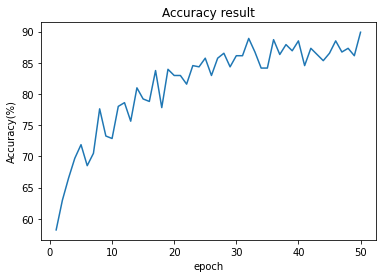

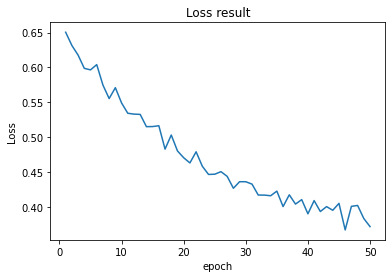

Done!


In [71]:
fit(50, resnet34, loss_fn, optimizer_resnet34)

Test6 experimental group(Try if use vgg)
When testing the vgg model, an error occurred showing that high usage of memory (DefaultCPUAllocator: not enough memory: you tried to allocate 3288334336 bytes.), which appears at epoch=14, thus we set it to epoch=12 to see the rough result.
(vgg epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008, batch size=256)
The speed of vgg learning is very fast, both the accuracy rate goes up and the loss value goes down, it seems that acc tends to stabilize at around 99.5 at epoch=5, while the loss value tends to stabilize at around 10 and floats around 0.2.

Start on CPU
Epoch 1
-------------------------------
loss: 0.777582  [    0/ 3008]
loss: 0.710556  [  512/ 3008]
loss: 0.721313  [ 1024/ 3008]
loss: 0.674149  [ 1536/ 3008]
loss: 0.648005  [ 2048/ 3008]
loss: 0.618565  [ 2560/ 3008]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.425955 

Epoch 2
-------------------------------
loss: 0.585121  [    0/ 3008]
loss: 0.561413  [  512/ 3008]
loss: 0.538181  [ 1024/ 3008]
loss: 0.540477  [ 1536/ 3008]
loss: 0.517165  [ 2048/ 3008]
loss: 0.494116  [ 2560/ 3008]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.324542 

Epoch 3
-------------------------------
loss: 0.462553  [    0/ 3008]
loss: 0.464252  [  512/ 3008]
loss: 0.443185  [ 1024/ 3008]
loss: 0.426719  [ 1536/ 3008]
loss: 0.417613  [ 2048/ 3008]
loss: 0.439706  [ 2560/ 3008]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.275126 

Epoch 4
-------------------------------
loss: 0.395363  [    0/ 3008]
loss: 0.385677  [  512/ 3008]
loss: 0.334329  [ 1024/ 3008]
loss: 0.362550  [ 1536/ 3008]
loss: 0.334

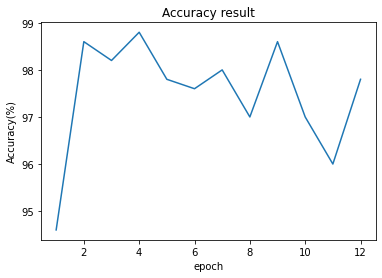

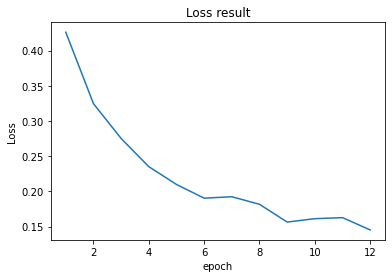

Done!


In [55]:
fit(12, vgg11, loss_fn, optimizer_vgg)

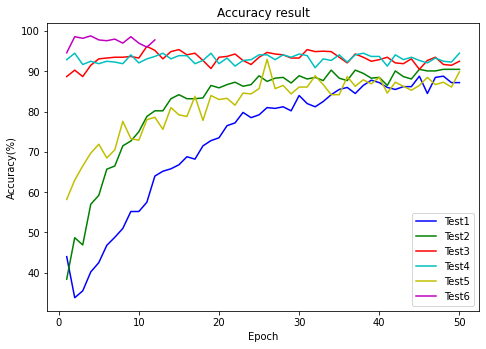

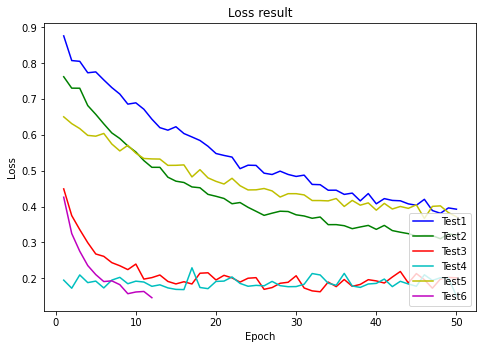

In [4]:
# Summary of transfer learning

Some bad results
Before the Test0-6 test, many tests of the model were conducted and the results were not found to be good, for the following reasons and results:

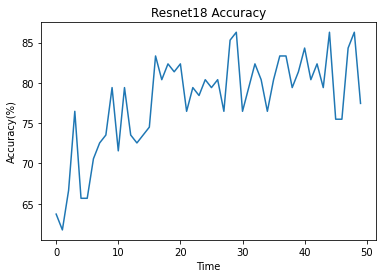

In [37]:
# This is over fitting because using small amount of training data(train dataset volume=500)

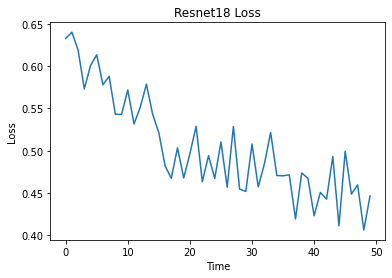

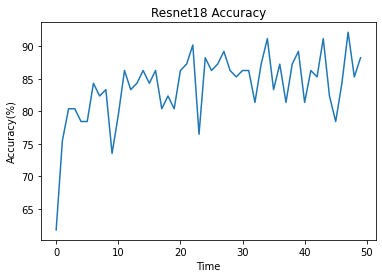

In [74]:
# This is over fitting because the pool quality of datasets(The mask is blurry and strange in the photo, and the face part in the photo is very small)

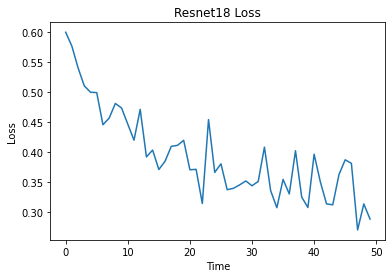

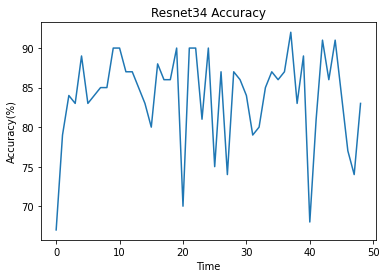

In [141]:
# over fitting, learning rate is too high

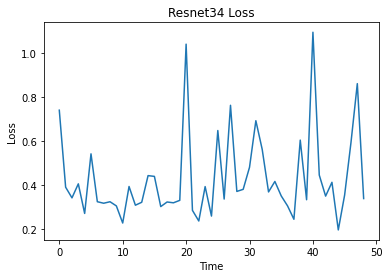

*Discussion: For 3000 data, it is more stable to use the adam optimizer and set the learning rate to 0.0001 resnet18. Resnet34 fluctuates slightly, and vgg rises fastest. If the learning rate is too high, it may lead to over fitting. For resnet34, because it has a deeper network structure, it requires more training time and less learning rate. The SGD optimizer may have larger data changes than the Adam optimizer, but due to momentum, it may skip the local minimum value to reach a new maximum accuracy or minimum loss value. The disadvantage of this experiment is that the data used is idealized (lack of side face, mask type, etc.), and there is no test training module for improper wearing of masks. In the future, this experiment can expand the test scope, such as testing more practical test data, testing the impact of epoch size on the experimental results, etc. If you want to use the camera for real-time testing, you need to add the CascadeClassifier module to extract facial parts.